In [1]:
%config Completer.use_jedi = False  # To avoid delays in autocompletion during coding.
import os
import sys
os.chdir('..')  # changing to a higher dir to access custom modules
cwd = os.getcwd()
sys.path.append(cwd)

import numpy as np  # numpy for matrix, linear-algebra, and other numerical studies.
import pandas as pd  # pandas for handling data similar to spreadsheet.
# import matplotlib as mpl  # matplotlib for plots
# import matplotlib.pyplot as plt  # for plots
# import seaborn as sb  # for styling of plots
from matplotlib_settings import *
from itertools import product
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from orientation_probabilities import map_rv2cos, map_rv2tan, map_rv2arctan, product_distr, ratio_distr
mpl.rcParams['figure.dpi'] = 150  # Reducing resolution of plots for better viewability in notebook.

In [2]:
# 3D isotropic orientation state of fibres
Nfibres = 1000
phiDistr = np.random.uniform(low=0, high=np.pi, size=Nfibres)
u  = np.random.rand(Nfibres)
thetaDistr = np.arccos(1 - 2*u)

alphaDistr = np.pi/2 + np.arctan(np.tan(thetaDistr) * np.cos(phiDistr))

print("\nSummary of phi: ")
print("min: {}, max: {}, mean: {}".format(phiDistr.min(), phiDistr.max(), phiDistr.mean()))
print("\nSummary of theta: ")
print("min: {}, max: {}, mean: {}".format(thetaDistr.min(), thetaDistr.max(), thetaDistr.mean()))
print("\nSummary of alpha: ")
print("min: {}, max: {}, mean: {}".format(alphaDistr.min(), alphaDistr.max(), alphaDistr.mean()))


Summary of phi: 
min: 0.001198291048006628, max: 3.1381247926702915, mean: 1.5445139064082818

Summary of theta: 
min: 0.07201744837133219, max: 3.126333454849819, mean: 1.5815104458042815

Summary of alpha: 
min: 0.003939130719878614, max: 3.1374466968656125, mean: 1.573989019451657


In [3]:
# Functions to estimate orientation and anisotropy tensors from a given probability distribution (histogram), 
# and further convert them to PMF.

def orient_tensor_2D(prob_phi, phi_vals):
    """
    Function to estimate orientation and anisotropy tensors from a given probability distribution (histogram).
    """
    if len(phi_vals) == len(prob_phi) + 1:
        phi_vals = 0.5 * (phi_vals[:-1] + phi_vals[1:])
    elif len(phi_vals) == len(prob_phi):
        pass
    else:
        raise ValueError("check dimensions of prob_phi and phi_vals: {0}, {1}".format(len(prob_phi), len(phi_valsDeg)))

    # check for total probability = 1
    d_phi = np.mean(phi_vals[1:] - phi_vals[:-1])  # mean bin width of phi values (delta_phi)
    total_prob = np.sum(prob_phi) * d_phi
    if not np.isclose(total_prob, 1.):
        print("Total probability not 1: {:1.2f}".format(total_prob))

    # setup
    order = 2
    coords = (0, 1)  # possible coordinates in 2D space
    base = tuple([coords] * order)  # tensor space dimension = coords * order
    indices = list(product(*base))  # all possible tensor indices Qijkl

    # direction cosines
    u = np.zeros((2, len(phi_vals)))
    u[0, :] = np.cos(phi_vals)
    u[1, :] = np.sin(phi_vals)

    # Orientation Tensor
    Q = []
    for indx in indices:
        # print("index: ", indx)
        elem = prob_phi
        for i in indx:
            elem = elem * u[i, :]
        Q.append(np.sum(elem))
    Q = np.array(Q).reshape((order, order)) * d_phi
    A = Q - 0.5*np.eye(order)
    
    return Q, A


def tensor2odf_2D(phivals, A):
    """
    Function to estimate PMF from tensor.
    """
    assert A.shape == (2, 2), 'Only two-dimensional tensors accepted'
    c = np.cos(phivals)
    s = np.sin(phivals)
    a = A.ravel()
    afunc = a[0] * (c*c - 0.5) + a[1] * (c*s) + a[2] * (s*c) + a[3] * (s*s - 0.5)
    odf = 1 / (2*np.pi) + (2 / np.pi) * afunc
    return odf


def fit_ODF(distr, bins):
    h, b = np.histogram(distr, bins=bins, density=True)
    Q, A = orient_tensor_2D(h, bins)
    binc = 0.5 * (bins[:-1] + bins[1:])
    odf = tensor2odf_2D(binc, A) * 2
    return odf

def fit_PMF(distr, bins):
    h, b = np.histogram(distr, bins=bins, density=True)
    c = 0.5 * (b[1:] + b[:-1])
    print(len(b))
    print(len(c))
    f = interp1d(c, h, kind='linear', fill_value='extrapolate')
    pmf = f(b)
    pmf = gaussian_filter1d(pmf, 1)
    total_prob = np.trapz(pmf, b)
    if not np.isclose(total_prob, 1.):
        print("Total probability not 1: {:1.2f}".format(total_prob))
    return pmf

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


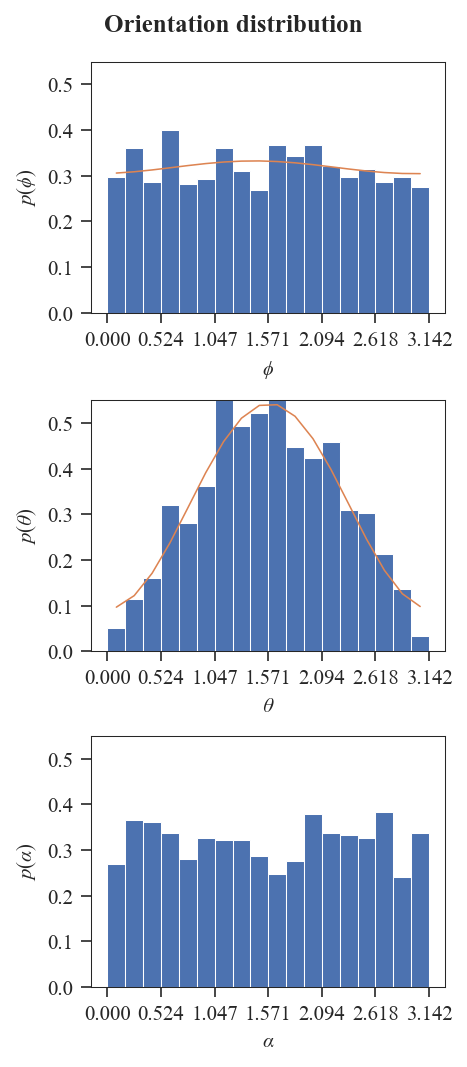

In [4]:
fig, axes = plt.subplots(3, 1, figsize=(3, 7))
axs = axes.ravel()
bins = np.deg2rad(np.arange(0, 181, 10))
binc = 0.5 * (bins[:-1] + bins[1:])

phiVals = binc
thetaVals = binc - np.pi/2

phiPMF = fit_ODF(phiDistr, bins)
thtPMF = fit_ODF(thetaDistr, bins)

# Phi
ax = axs[0]
h, b, _ = ax.hist(phiDistr, bins=bins, density=True)
ax.plot(binc, phiPMF, lw=0.75)
ax.set_xlabel('$\phi$')
ax.set_ylabel('$p(\phi)$')
ax.set_xticks(b[::3])

# Theta
ax = axs[1]
h, b, _ = ax.hist(thetaDistr, bins=bins, density=True)
ax.plot(binc, thtPMF, lw=0.75)
ax.set_xlabel('$\\theta$')
ax.set_ylabel('$p(\\theta)$')
ax.set_xticks(b[::3])

# Alpha
ax = axs[2]
h, b, _ = ax.hist(alphaDistr, bins=bins, density=True)
ax.set_xlabel('$\\alpha$')
ax.set_ylabel('$p(\\alpha)$')
ax.set_xticks(b[::3])

for ax in axs:
    ax.set_ylim([0, 0.55])

fig.suptitle('Orientation distribution')
plt.show()

In [5]:
# cos_phiVals = np.cos(phiVals)[::-1]
# cos_phi_PMF = map_rv2cos(phiVals, phiPMF, cos_phiVals)
# cos_phiDistr = np.cos(phiDistr)

# tan_thtVals = np.tan(thetaVals)
# tan_tht_PMF = map_rv2tan(thetaVals, thtPMF, tan_thtVals)
# tan_thtDistr = np.tan(thetaVals)

# cos_phiTP = np.trapz(cos_phi_PMF, cos_phiVals)
# tan_thtTP = np.trapz(tan_tht_PMF, tan_thtVals)
# print("Total probability of cos(phi): ", cos_phiTP)
# print("Total probability of tan(theta): ", tan_thtTP)
# cos_phi_PMF = cos_phi_PMF / cos_phiTP
# tan_tht_PMF = tan_tht_PMF / tan_thtTP

# fig, axes = plt.subplots(1, 2, figsize=(4, 2), dpi=300)
# axs = axes.ravel()
# ax = axs[0]
# h, b, _ = ax.hist(cos_phiDistr, bins=np.cos(bins)[::-1], density=True)
# ax.plot(cos_phiVals, cos_phi_PMF , lw=0.75, label="$p(\cos\\alpha)$")
# # ax.legend()
# ax = axs[1]
# h, b, _ = ax.hist(tan_thtDistr, bins=np.tan(bins-np.pi/2)[1:-1], density=True)
# ax.plot(tan_thtVals, tan_tht_PMF, lw=0.75, label="$p(\tan\\theta)$")

In [6]:
# # tan_alpVals = tan_thtVals
# tan_alpVals = np.linspace(-5, 5, len(tan_thtVals))
# # print(tan_alpVals)
# tan_alp_PMF = product_distr(tan_thtVals, cos_phiVals, tan_alpVals, tan_tht_PMF,\
#                             cos_phi_PMF, atol=1e-8)
# tan_alp_TP = np.trapz(tan_alp_PMF, tan_alpVals)
# tan_alp_PMF = tan_alp_PMF / tan_alp_TP
# print("Total probability of tan(alpha): ", np.trapz(tan_alp_PMF, tan_alpVals))

# y_reciprocal = gaussian_filter1d(np.abs(1 / cos_phiVals), 2)
# lim = 0.5 * np.trapz(cos_phi_PMF * y_reciprocal, cos_phiVals)
# print("Limitng value: ", lim)

# f1 = plt.figure()
# ax1 = f1.gca()
# # ax1.plot(cos_phiVals, y_reciprocal)
# ax1.plot(cos_phiVals, cos_phi_PMF)
# ax1.plot(cos_phiVals, 0.5 * y_reciprocal * cos_phi_PMF)

# fig = plt.figure(figsize=(3.5, 2), dpi=300)
# ax = fig.gca()
# h, b, _ = ax.hist(np.tan(alphaDistr), bins=tan_alpVals, density=True)
# ax.plot(tan_alpVals, gaussian_filter1d(tan_alp_PMF, 1), lw=0.75, label="$p(\\tan\\alpha)$")
# ax.set_xlabel('$\\tan\\alpha$')
# ax.legend()

In [7]:
# # arctan of tan theta
# tht2PMF = map_rv2arctan(tan_thtVals, tan_tht_PMF, thetaVals)

# fig = plt.figure()
# ax = fig.gca()
# h, b, _ = ax.hist(thetaDistr-np.pi/2, bins=bins-np.pi/2, density=True)
# ax.plot(thetaVals, tht2PMF, lw=0.75)
# ax.set_xlabel('$\\theta$')
# ax.set_ylabel('$p(\\theta)$')
# ax.set_xticks(b[::3])

In [8]:
# # arctan of tan alpha
# alpPMF = map_rv2arctan(tan_alpVals, tan_alp_PMF, thetaVals)

# fig = plt.figure()
# ax = fig.gca()
# h, b, _ = ax.hist(alphaDistr-np.pi/2, bins=bins-np.pi/2, density=True)
# ax.plot(thetaVals[1:-1], alpPMF[1:-1], lw=0.75)
# ax.set_xlabel('$\\theta$')
# ax.set_ylabel('$p(\\theta)$')
# ax.set_xticks(b[::3])

18
17
Total probability not 1: 1.00


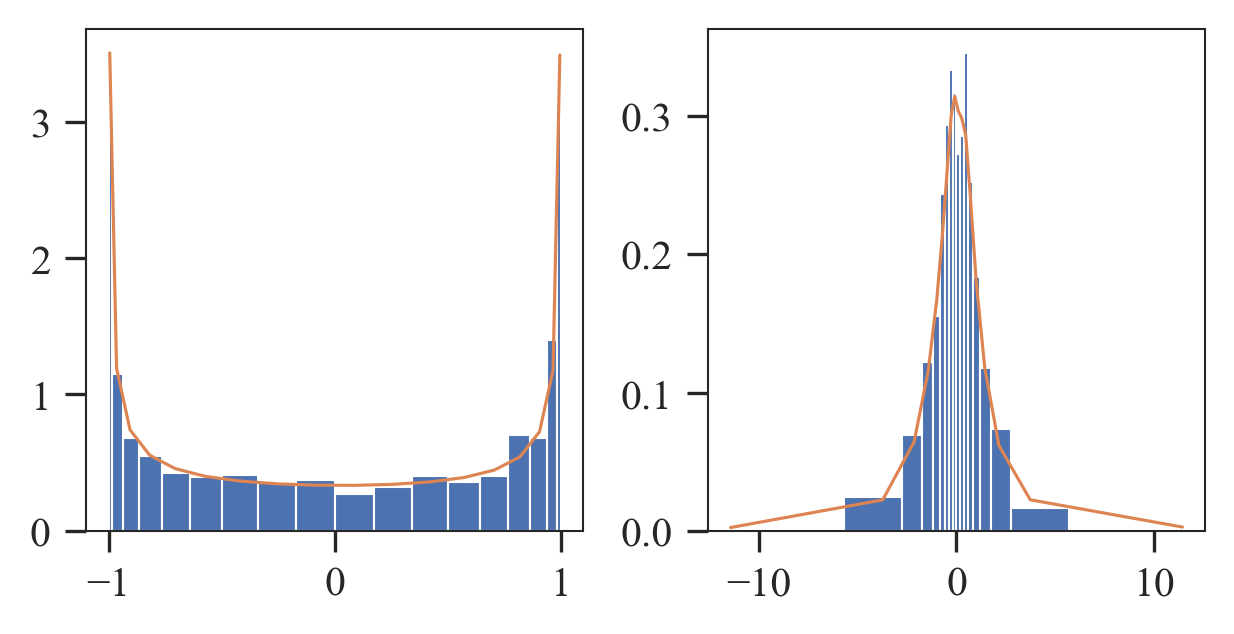

In [12]:
cos_phiVals = np.cos(phiVals)[::-1]
cos_phi_PMF = map_rv2cos(phiVals, phiPMF, cos_phiVals)
cos_phiDistr = np.cos(phiDistr)

alpPMF = fit_PMF(alphaDistr, binc)
alphaVals = binc - np.pi/2
tan_alpVals = np.tan(alphaVals)
tan_alp_PMF = map_rv2tan(alphaVals, alpPMF, tan_alpVals)
tan_alpDistr = np.tan(alphaDistr-np.pi/2)

fig, axes = plt.subplots(1, 2, figsize=(4, 2), dpi=300)
axs = axes.ravel()
ax = axs[0]
h, b, _ = ax.hist(cos_phiDistr, bins=np.cos(bins)[::-1], density=True)
ax.plot(cos_phiVals, cos_phi_PMF , lw=0.75, label="$p(\cos\\phi)$")

ax = axs[1]
h, b, _ = ax.hist(tan_alpDistr, bins=np.tan(bins-np.pi/2)[1:-1], density=True)
ax.plot(tan_alpVals, tan_alp_PMF, lw=0.75, label="$p(\tan\\alpha)$")

### Logarithmic Distribution
$Z = \ln(X)$,
then
$$
\begin{align}
    F_Z(z)  &= P\{Z \leq z\}\\
            &= P\{\ln(X) \leq z\}\\
            &= P\{X \leq e^{z}\}\\
            &= F_X(x=e^{z})
\end{align}
$$
The PDF is
$$
\begin{align}
    f_Z(z)  &= \frac{d}{dz} F_X(x=e^z)\\
            &= e^z\ f_X(x=e^z) 
\end{align}
$$

### Exponential Distribution
$Z = e^X$,
then
$$
\begin{align}
    F_Z(z)  &= P\{Z \leq z\}\\
            &= P\{e^X \leq z\}\\
            &= P\{X \leq \ln{z}\}\\
            &= F_X(x=\ln{z})
\end{align}
$$
The PDF is
$$
\begin{align}
    f_Z(z)  &= \frac{d}{dz} F_X(x=\ln{z})\\
            &= \frac{1}{z}\ f_X(x=\ln{z}) 
\end{align}
$$

In [59]:
x = cos_phiVals
pmfx = cos_phi_PMF
y = tan_alpVals
pmfy = tan_alp_PMF

lnx = np.log(x)
lny = np.log(y)

lnz = lny - lnx
z = np.exp(lnz)
pmflnz = np.convolve(x**2 * pmfx, y*pmfy, 'same')
pmfz = -pmflnz / z
for i in range(len(pmfz) // 2 + 1):
    pmfz[i] = pmfz[-i-1]
    z[i] = -z[-i-1]
print(z)


[-11.47371325  -3.86370331  -2.36620158  -1.7434468   -1.41421356
  -1.22077459  -1.10337792  -1.03527618  -1.00381984   1.00381984
   1.03527618   1.10337792   1.22077459   1.41421356   1.7434468
   2.36620158   3.86370331  11.47371325]


<ipython-input-59-957cb4684ca4>:6: RuntimeWarning: invalid value encountered in log
  lnx = np.log(x)
<ipython-input-59-957cb4684ca4>:7: RuntimeWarning: invalid value encountered in log
  lny = np.log(y)


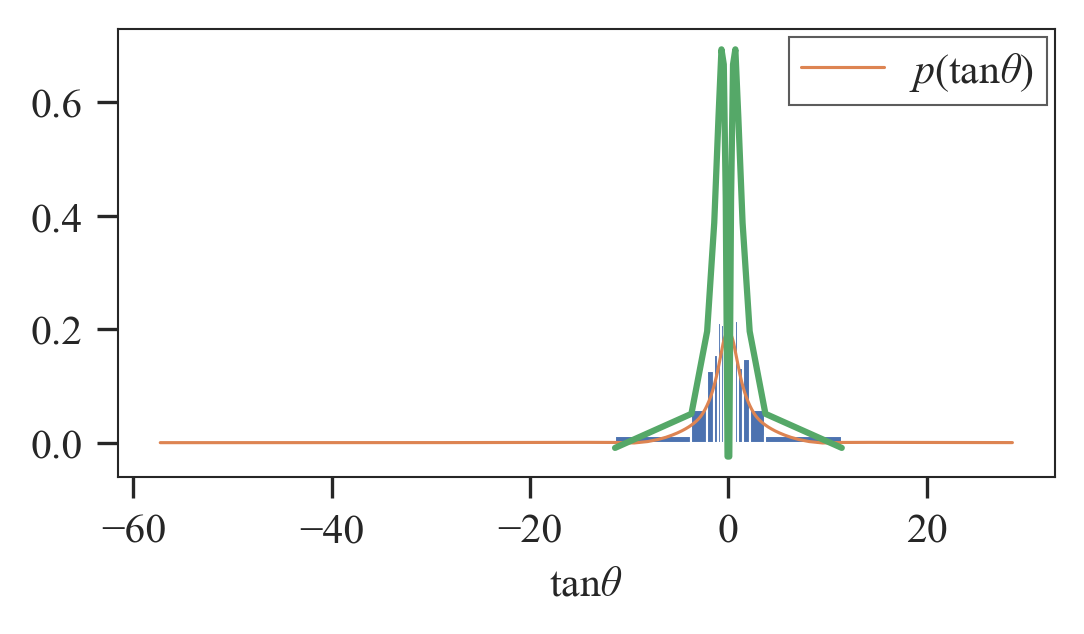

In [60]:
tan_thtVals = np.tan(np.deg2rad(np.arange(1, 179)) - np.pi/2)
tan_tht_PMF = ratio_distr(tan_alpVals, cos_phiVals, tan_thtVals, tan_alp_PMF, cos_phi_PMF)

tan_thtDistr = np.tan(thetaDistr)

fig = plt.figure(figsize=(3.5, 2), dpi=300)
ax = fig.gca()
h, b, _ = ax.hist(tan_thtDistr, bins=tan_alpVals, density=True)
ax.plot(tan_thtVals,tan_tht_PMF, lw=0.75, label="$p(\\tan\\theta)$")
ax.plot(tan_alpVals, pmfz)
ax.set_xlabel('$\\tan\\theta$')
ax.legend()

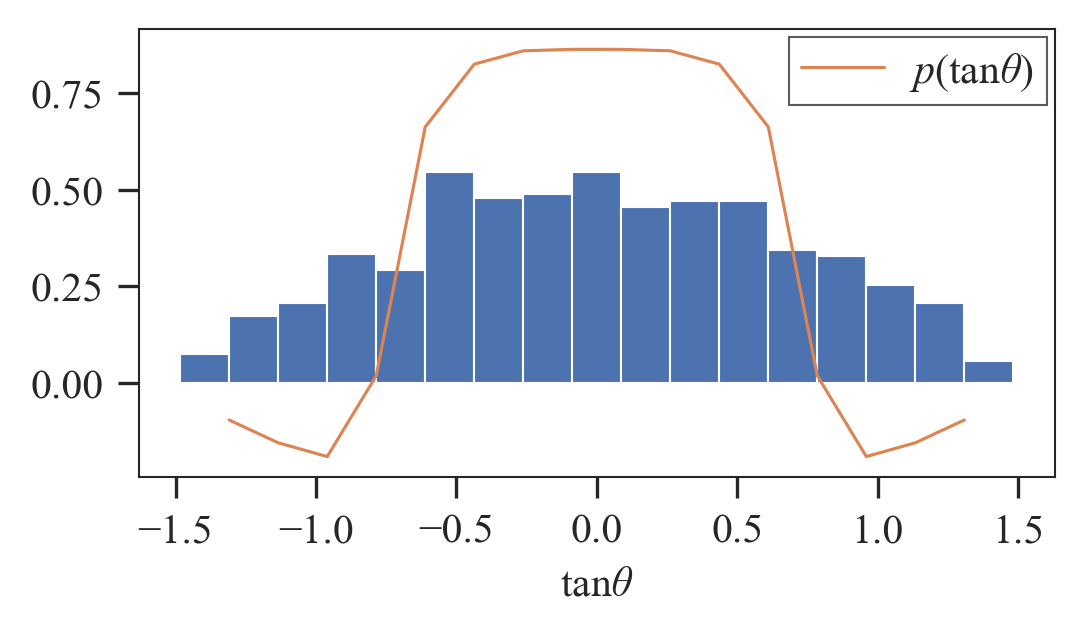

In [61]:
tht2PMF = map_rv2arctan(z, pmfz, thetaVals)
tht2PMF = tht2PMF / np.trapz(tht2PMF, thetaVals)

fig = plt.figure(figsize=(3.5, 2), dpi=300)
ax = fig.gca()
h, b, _ = ax.hist(thetaDistr - np.pi/2, bins=thetaVals, density=True)
ax.plot(thetaVals[1:-1], tht2PMF[1:-1], lw=0.75, label="$p(\\tan\\theta)$")
ax.set_xlabel('$\\tan\\theta$')
ax.legend()